<a href="https://colab.research.google.com/github/pradlanka/Apziva/blob/main/EgwgsEeWZem4iXIs/MonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Background:

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.



Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

Download Data:

https://drive.google.com/file/d/1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm/view?usp=sharing

Goal(s):

Predict if the page is being flipped using a single image.

Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

Bonus(es):

Predict if a given sequence of images contains an action of flipping.

**To solve this problem. We will use convolutional neural networks as well as transfer learning, where we will use the inception network and reatrain the dense network to the images. To solve if the sequence if images contain the action of flipping, we will use 3D CNNs as well as CNN with sequence models.**

##**1. Load the data**

In [2]:
# Connect and mount Google drive that contains the images
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip and the zip file containing images
import zipfile
local_zip = '/content/drive/My Drive/images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/My Drive/images')
zip_ref.close()


In [3]:
# Set folder paths containing images folder and the training and test data
import os
base_dir = '/content/drive/My Drive/images/images/'
train_dir = os.path.join(base_dir , 'training') # Training data path
test_dir = os.path.join(base_dir ,'testing') # Test data path

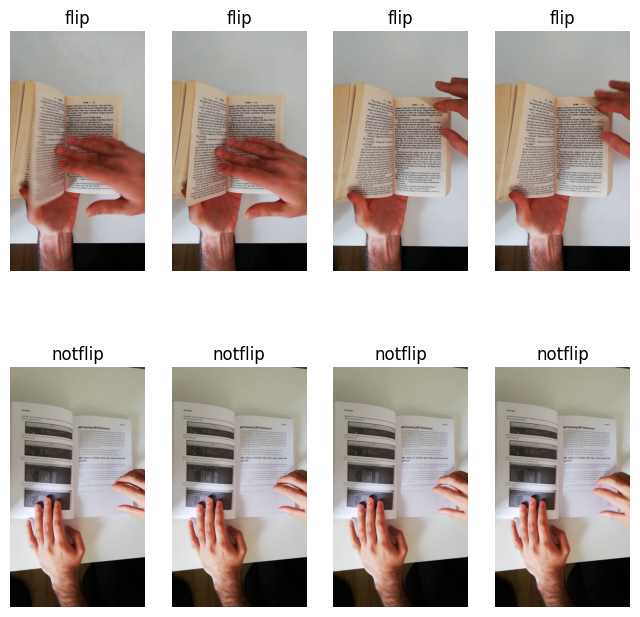

In [3]:
# Visualize a few training examples of the images from each class to better sense
# of the problem

from matplotlib import pyplot as plt
from pathlib import Path

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Data path to classes
flip_dir = os.path.join(train_dir ,"flip")
notflip_dir = os.path.join(train_dir, "notflip")

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4

pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*4)

pic_index+=8

flip_pix = [os.path.join(flip_dir, fname)
                for fname in os.listdir(flip_dir)[ pic_index-4:pic_index]
               ]

not_flip_pix = [os.path.join(notflip_dir, fname)
                for fname in os.listdir(notflip_dir)[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(flip_pix + not_flip_pix ):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.title.set_text(os.path.basename(os.path.dirname(img_path)))
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

From the examples, it is clear theat the major differentiating factor between page flips and page no-flips is that the right hand is over the paper in the page no-flips and it is under the paper in the non-flips. So the convolutional neural networks can utlize this feature to succeed in the classification task

In [38]:
# Loading the training data and the test data. We will use a subset (0.2) of the
# training data for validation. We are further using data augmentation including
# roation, shifts, zoom and shear that improves the classifier performance and
# avoid overfitting. We would not augment the test data.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

 # Initialize the ImageDataGenerator with a validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False, # No point in flipping
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of the data for validation
)

# Setup the training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(320, 180),
    batch_size=100,
    class_mode='binary',
    subset='training'  # Specify to use the training subset
)

# Setup the validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(320, 180),
    batch_size=100,
    class_mode='binary',
    subset='validation'  # Specify to use the validation subset
)

test_datagen = ImageDataGenerator(
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(320, 180),
    batch_size=100,
    class_mode='binary')

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


## **2. Model building**

### **2.1 Convolution neural networks**

In [39]:
# Define the F1 score metric function
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [40]:
# Building the CNN  classifier with 3 convolution and MaxPool layers followed by
# 1 fully connected network

from tensorflow.keras import layers, models
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Defining the optimizer
optimizer = Adam(learning_rate=0.0001) # Lowering the default learning rate

input_shape = (320, 180, 3) # Defining the shape of the image being loaded.
# The image is being downscaled from its oringinal resoltion of 1920 x 1080

# Build the CNN model using Sequential API in Keras
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.8), # Dropout for regularization
    layers.Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score])

# Implement early stopping to avoid overfitting
# and reduce the trainig time if model stops improving
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=1,
                               restore_best_weights=True)

AdAdd more fully-connected and less convolution layers
Add batch norm layers


In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 318, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 159, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 157, 87, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 78, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 76, 41, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 38, 20, 128)      

The CNN model has over 12M trainable parameters.

In [42]:
# Fitting the model and training it for 100 epochs, since we are implementing
# early stopping we can set epoch number to be a bit high.
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping])

Epoch 1/100
19/19 [==============================] - 99s 5s/step - loss: 0.7268 - accuracy: 0.4983 - f1_score: 0.5411 - val_loss: 0.6890 - val_accuracy: 0.5350 - val_f1_score: 0.6969
Epoch 2/100
19/19 [==============================] - 55s 3s/step - loss: 0.6959 - accuracy: 0.5017 - f1_score: 0.4905 - val_loss: 0.6906 - val_accuracy: 0.5475 - val_f1_score: 0.6978
Epoch 3/100
19/19 [==============================] - 55s 3s/step - loss: 0.6906 - accuracy: 0.5358 - f1_score: 0.6318 - val_loss: 0.6905 - val_accuracy: 0.5850 - val_f1_score: 0.6662
Epoch 4/100
19/19 [==============================] - 54s 3s/step - loss: 0.6874 - accuracy: 0.5562 - f1_score: 0.6278 - val_loss: 0.6915 - val_accuracy: 0.4775 - val_f1_score: 0.3503
Epoch 5/100
19/19 [==============================] - 55s 3s/step - loss: 0.6751 - accuracy: 0.5888 - f1_score: 0.6246 - val_loss: 0.6840 - val_accuracy: 0.5325 - val_f1_score: 0.5461
Epoch 6/100
19/19 [==============================] - 55s 3s/step - loss: 0.6714 - acc

In [44]:
import matplotlib.pyplot as plt
def plot_history(history):
  # Retrieve a list of list results on training and validation data
  # sets for each training epoch
  acc=history.history['accuracy'] # Training accuracy
  val_acc=history.history['val_accuracy'] # Validation accuracy
  loss=history.history['loss'] # Training cross-entropy loss
  val_loss=history.history['val_loss'] # Validation cross-entropy loss

  epochs=range(len(acc)) # Get number of epochs

  fig, (ax1, ax2) = plt.subplots(2)
  plt.subplots_adjust(hspace=0.6)

  # Plot training and validation accuracy per epoch
  ax1.plot(epochs, acc, 'r', label = "Training Accuracy")
  ax1.plot(epochs, val_acc, 'b', label  = "Validation Accuracy")
  ax1.set_title('Training and validation accuracy')
  ax1.legend()
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Accuracy")

  # Plot training and validation loss per epoch
  ax2.plot(epochs, loss, 'r', label  = "Training Loss")
  ax2.plot(epochs, val_loss, 'b', label = "Validation Loss")
  ax2.set_title('Training and validation loss')
  ax2.legend()
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Loss")
  plt.show()

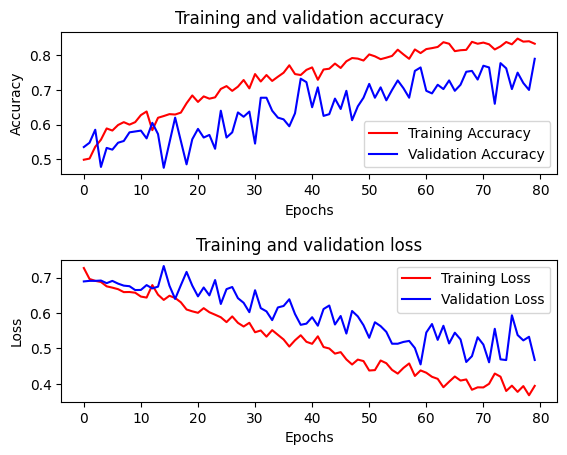

In [47]:
plot_history(history)

1/1 [==============================] - 0s 389ms/step


<ipython-input-46-e581daac9ef0>:67: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-46-e581daac9ef0>:70: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


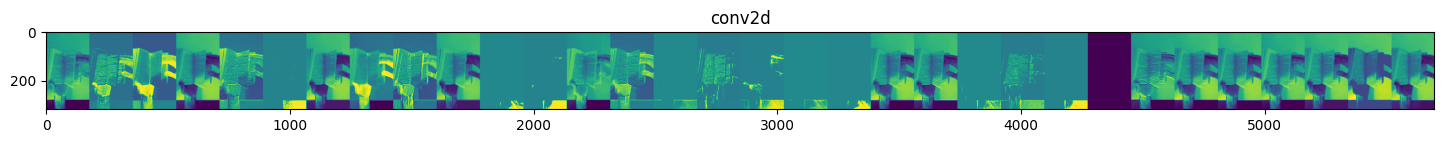

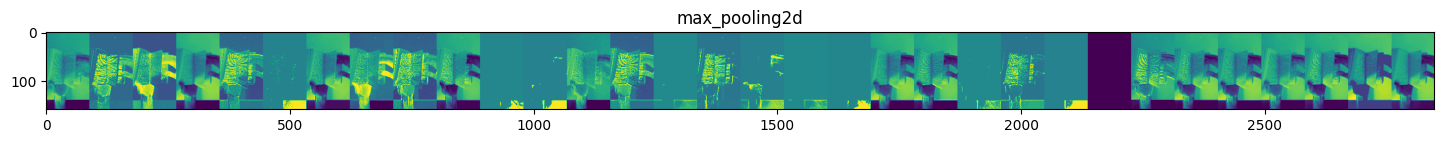

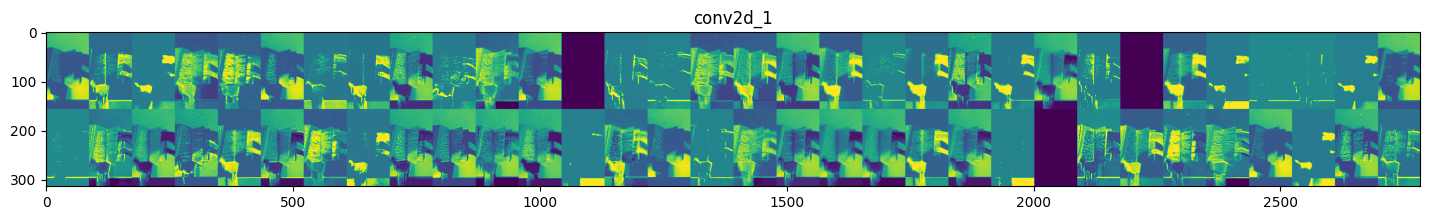

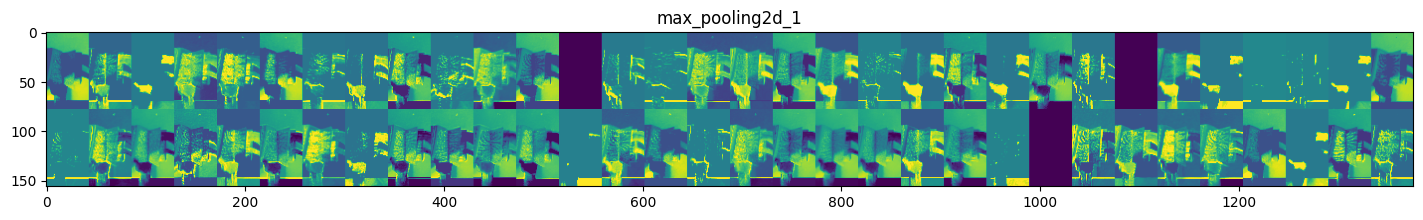

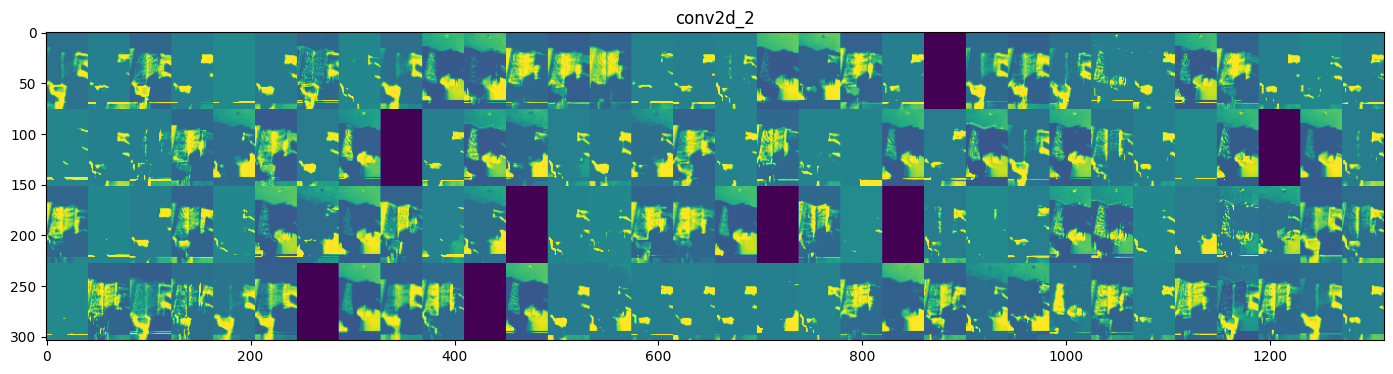

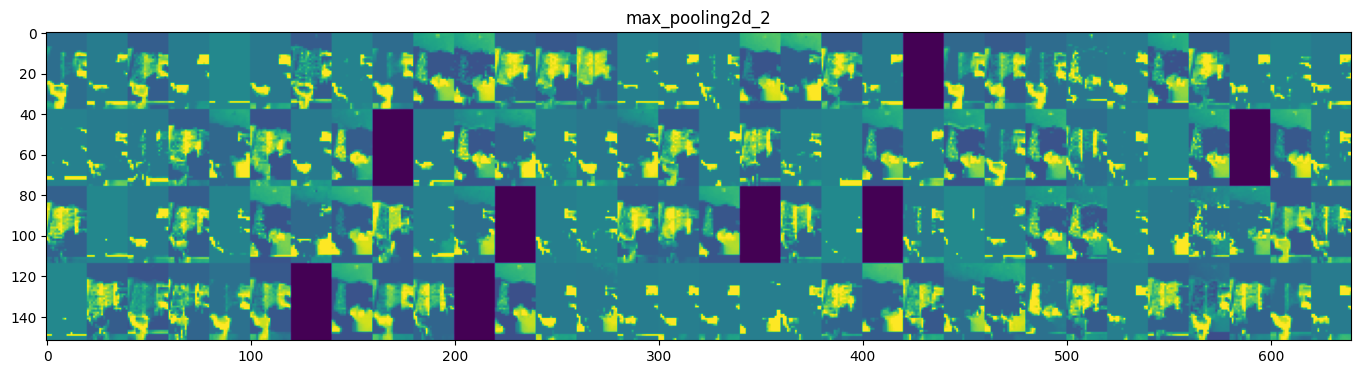

In [46]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, load_img
import matplotlib.pyplot as plt
import os

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)


# Data path to classes
flip_dir = os.path.join(train_dir ,"flip")
notflip_dir = os.path.join(train_dir, "notflip")

# Prepare a random input image from the training set.
flip_img_files = [os.path.join(flip_dir, f) for f in os.listdir(flip_dir)]
notflip_img_files = [os.path.join(notflip_dir, f) for f in os.listdir(notflip_dir)]
img_path = random.choice(flip_img_files + notflip_img_files)

img = load_img(img_path, target_size=(320, 180))
x = img_to_array(img)  # Numpy array with shape (320, 180, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 320, 180, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers]

# Set a fixed width for the display grid (in terms of number of columns)
fixed_cols = 32  # You can adjust this value based on your needs

# Function to calculate the number of rows and columns based on the fixed columns
def calculate_grid(n_features, feature_map_shape, fixed_cols):
    dim1, dim2 = feature_map_shape
    n_cols = min(fixed_cols, n_features)
    n_rows = int(np.ceil(n_features / n_cols))
    return n_rows, n_cols

# Display the representations
for index, (layer_name, feature_map) in enumerate(zip(layer_names, successive_feature_maps)):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map

        # The feature map has shape (1, dim1, dim2, n_features)
        dim1 = feature_map.shape[1]
        dim2 = feature_map.shape[2]

        # Calculate the number of rows and columns for the current layer
        n_rows, n_cols = calculate_grid(n_features, (dim1, dim2), fixed_cols)

        # Create a grid layout to place the activation maps
        display_grid = np.zeros((n_rows * dim1, n_cols * dim2))

        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Calculate the row and column for this filter
            row = i // n_cols
            col = i % n_cols

            # Place each filter into this big grid
            display_grid[row * dim1:(row + 1) * dim1, col * dim2:(col + 1) * dim2] = x

        # Display the grid
        scale = 1. / dim1
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

In [48]:
# Evalaute the performance of the model on the test dataset

test_loss, test_acc, test_f1 = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest F1 score:', test_f1)


6/6 - 19s - loss: 0.2468 - accuracy: 0.9028 - f1_score: 0.9113 - 19s/epoch - 3s/step

Test accuracy: 0.9028475880622864

Test F1 score: 0.9113102555274963


In [49]:
# Save the model weights, history and everything esle
import pickle

#Save the model
model.save('/content/drive/My Drive/CNN3_model.keras')

with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [50]:
from keras.models import load_model
import pickle

#Load the model
custom_objects={'f1_score': f1_score}
model = load_model('/content/drive/My Drive/CNN3_model.keras', custom_objects=custom_objects)


# Load the history object
with open('history.pkl', 'rb') as file:
    history = pickle.load(file)


### **2.2 Using Transfer learning with Inception**

We will use layers in the Inception model and remove the toplayers and replace it with a fully connected layer and a sigmoid output layer. Then only train the weights in the top 2 layers.

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

input_shape = (320, 180, 3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = input_shape)

# Freeze the base model
# i.e. freeze InceptionV3 layers and train until 'mixed7' layer
for layer in base_model.layers:
    if layer.name == 'mixed7':
        break
    layer.trainable = False

# Add a global spatial average pooling layer
x = base_model.output
x =  layers.GlobalAveragePooling2D()(x)

# Adding a fully connected layer
x =  layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.8)(x)
# Add a sigmoid layer for binary classification
predictions =   layers.Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)

# compile the model
model2.compile(optimizer='Adam',  loss='binary_crossentropy',
              metrics=['accuracy', f1_score])

# Implement early stopping to avoid overfitting
# and reduce the trainig time if model stops improving
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=1,
                               restore_best_weights=True)

# Training the model for 100 epochs
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping])

Epoch 1/100
19/19 [==============================] - 152s 7s/step - loss: 0.5080 - accuracy: 0.7641 - f1_score: 0.7649 - val_loss: 17.7546 - val_accuracy: 0.5350 - val_f1_score: 0.6865
Epoch 2/100
19/19 [==============================] - 56s 3s/step - loss: 0.3130 - accuracy: 0.8771 - f1_score: 0.8836 - val_loss: 3.9486 - val_accuracy: 0.6350 - val_f1_score: 0.7379
Epoch 3/100
19/19 [==============================] - 56s 3s/step - loss: 0.2765 - accuracy: 0.8986 - f1_score: 0.8854 - val_loss: 3.5594 - val_accuracy: 0.6925 - val_f1_score: 0.7695
Epoch 4/100
19/19 [==============================] - 56s 3s/step - loss: 0.2203 - accuracy: 0.9085 - f1_score: 0.9083 - val_loss: 0.9301 - val_accuracy: 0.8325 - val_f1_score: 0.8451
Epoch 5/100
19/19 [==============================] - 56s 3s/step - loss: 0.2231 - accuracy: 0.9283 - f1_score: 0.9340 - val_loss: 1.0235 - val_accuracy: 0.8125 - val_f1_score: 0.8139
Epoch 6/100
19/19 [==============================] - 56s 3s/step - loss: 0.1592 - a

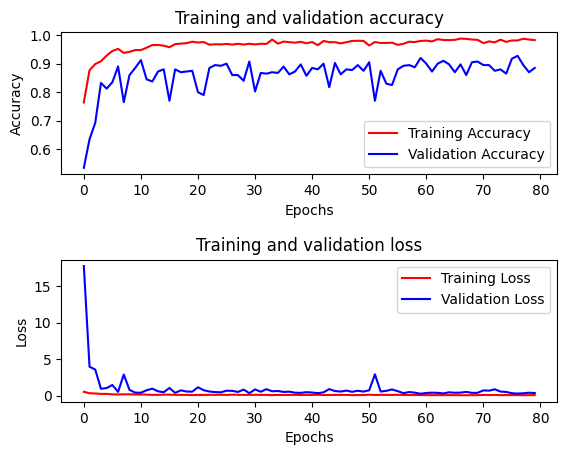

In [ ]:
# Evalaute the performance of the model on the test dataset
plot_history(history2)

In [ ]:
# Evalaute the performance of the model on the test dataset

test_loss, test_acc, test_f1 = model2.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest F1 score:', test_f1)


6/6 - 20s - loss: 0.0405 - accuracy: 0.9832 - f1_score: 0.9837 - 20s/epoch - 3s/step

Test accuracy: 0.9832496047019958

Test F1 score: 0.9837026596069336


In [ ]:
# Save the model weights, history and everything esle

import pickle

#Save the model
model2.save('/content/drive/My Drive/Inceptune_model.keras')

with open('history2.pkl', 'wb') as file:
    pickle.dump(history2.history, file)

In [28]:
from keras.models import load_model
import pickle

#Load the model

custom_objects={'f1_score': f1_score}
model2 = load_model('/content/drive/My Drive/Inceptune_model.keras', custom_objects=custom_objects)


# Load the history object
with open('history2.pkl', 'rb') as file:
    history2 = pickle.load(file)

##**3. Training a sequence of images to detect flip or no flip**

###**3.1 Using 3D Convolution Neural Nets**

In [23]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class FrameSequenceGenerator(Sequence):
    def __init__(self, directory, batch_size, num_frames, target_size, shuffle=True, validation_split=0.2, subset='training'):
        self.directory = directory
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.target_size = target_size
        self.shuffle = shuffle
        self.classes_dict, self.video_dict, self.labels_vids  = self._prepare_data()
        self.subset = subset
        self.validation_split = validation_split
        self.video_ids = self._split_data()
        self.on_epoch_end()

    def _prepare_data(self):
        video_dict = {}
        classes_dict = {}
        labels_vids ={}
        for i, classes in enumerate(os.listdir(self.directory)):
          classes_dict [i] = classes
          for file_name in os.listdir(os.path.join(self.directory, classes)):
            if file_name.endswith('.jpg'):
                video_id, frame_number = file_name.split('_')
                video_id = classes+video_id
                frame_number = int(frame_number.split('.')[0])
                if video_id not in video_dict:
                    video_dict[video_id] = []
                    labels_vids[video_id] = i
                video_dict[video_id].append((frame_number,classes, file_name))


        for video_id in video_dict:
            video_dict[video_id].sort()

        return classes_dict, video_dict, labels_vids

    def _split_data(self):
        video_ids = list(self.video_dict.keys())
        np.random.shuffle(video_ids)
        split_idx = int(len(video_ids) * (1 - self.validation_split))
        if self.subset == 'training':
            return video_ids[:split_idx]
        else:
            return video_ids[split_idx:]

    def __len__(self):
        return len(self.video_ids) // self.batch_size

    def __getitem__(self, index):
        batch_video_ids = self.video_ids[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_video_ids)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.video_ids)

    def __data_generation(self, batch_video_ids):
        X = np.empty((self.batch_size, self.num_frames, *self.target_size, 3))
        y = np.empty((self.batch_size,), dtype=int)  # Assuming labels are integers

        for i, video_id in enumerate(batch_video_ids):
            frames = self.video_dict[video_id][:self.num_frames]
            for j, (frame_number, classes, file_name) in enumerate(frames):
                img_path = os.path.join(self.directory, classes,  file_name)
                img = load_img(img_path, target_size=self.target_size)
                img_array = img_to_array(img)
                X[i, j, ...] = img_array / 255.0  # Normalize the image to be betwn 0 and1

            y[i] = self.labels_vids[video_id] # Extracting label ID

        return X, y


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import os

# Parameters
num_frames = 10  # Number of frames per video clip. We will just use the first 10 frames. So as to be fair across all sequences
batch_size = 4
target_size = (320, 180) # Each image size
input_shape = (num_frames, *target_size , 3)  # Define the input shape

# Build the 3D CNN model
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv3D(32, kernel_size=(1, 3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Conv3D(128, kernel_size=(1, 3, 3), activation='relu',  padding='same'),
        layers.MaxPooling3D(pool_size=(2, 2, 2),  padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.8), # Dropout for regularization
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model3 = build_model(input_shape)
model3.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', f1_score])

# Summary of the model
model3.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 10, 318, 178, 32   896       
                             )                                   
                                                                 
 max_pooling3d_21 (MaxPooli  (None, 5, 159, 89, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_22 (Conv3D)          (None, 5, 157, 87, 64)    18496     
                                                                 
 max_pooling3d_22 (MaxPooli  (None, 2, 78, 43, 64)     0         
 ng3D)                                                           
                                                                 
 conv3d_23 (Conv3D)          (None, 2, 78, 43, 128)    73856     
                                                     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# training, validation and test generators
validation_split = 0.1
train_generator = FrameSequenceGenerator(train_dir, batch_size, num_frames, target_size, validation_split=validation_split, subset='training')
validation_generator = FrameSequenceGenerator(train_dir, batch_size, num_frames, target_size,  validation_split=validation_split, subset='validation')
test_generator = FrameSequenceGenerator(test_dir, batch_size, num_frames, target_size, validation_split=0.0, subset='training')

# Implement early stopping to avoid overfitting
# and reduce the trainig time if model stops improving
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=1,
                               restore_best_weights=True)


# Train the model for 50 epochs
history3 = model3.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping])


Epoch 1/50
26/26 [==============================] - 15s 578ms/step - loss: 0.3782 - accuracy: 0.9231 - f1_score: 0.8253 - val_loss: 0.2543 - val_accuracy: 0.9167 - val_f1_score: 0.8889
Epoch 2/50
26/26 [==============================] - 15s 586ms/step - loss: 0.3422 - accuracy: 0.9038 - f1_score: 0.8449 - val_loss: 0.1713 - val_accuracy: 0.9167 - val_f1_score: 0.8889
Epoch 3/50
26/26 [==============================] - 14s 545ms/step - loss: 0.1445 - accuracy: 0.9615 - f1_score: 0.7667 - val_loss: 0.1380 - val_accuracy: 0.9167 - val_f1_score: 0.8889
Epoch 4/50
26/26 [==============================] - 15s 576ms/step - loss: 0.0899 - accuracy: 0.9615 - f1_score: 0.8449 - val_loss: 0.0411 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 5/50
26/26 [==============================] - 15s 567ms/step - loss: 0.1335 - accuracy: 0.9231 - f1_score: 0.7744 - val_loss: 0.1899 - val_accuracy: 0.9167 - val_f1_score: 0.9333
Epoch 6/50
26/26 [==============================] - 15s 579ms/step - loss: 

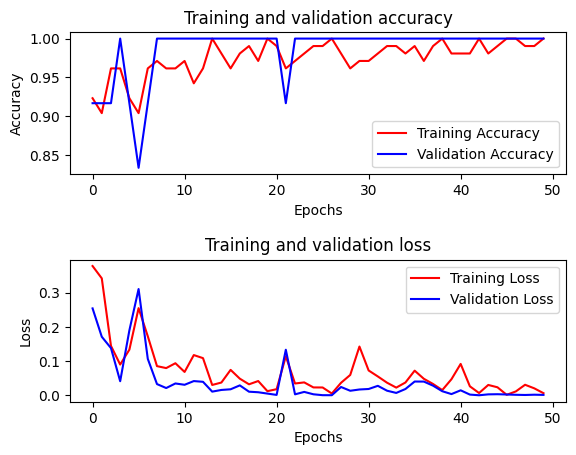

In [ ]:
plot_history(history3)

In [ ]:
# Evalaute the performance of the model on the test dataset

test_loss, test_acc, test_f1 = model3.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest F1 score:', test_f1)


28/28 - 7s - loss: 0.9366 - accuracy: 0.7589 - f1_score: 0.7124 - 7s/epoch - 267ms/step

Test accuracy: 0.7589285969734192

Test F1 score: 0.7124148607254028


In [ ]:
# Save the model weights, history and everything esle
import pickle

#Save the model

model3.save('/content/drive/My Drive/3D_CNN_model.keras')

#Save the history object

with open('history3.pkl', 'wb') as file:
    pickle.dump(history3.history, file)

In [ ]:
from keras.models import load_model
import pickle

#Load the model

custom_objects={'f1_score': f1_score}
model3 = load_model('/content/drive/My Drive/3D_CNN_model.keras', custom_objects=custom_objects)


# Load the history object
with open('history3.pkl', 'rb') as file:
    history3 = pickle.load(file)

###**3.2 Using Convolution Neural Nets with  sequence models (LSTM)**

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Parameters
num_frames = 10  # Number of frames per video clip. We will just use the first 10 frames. So as to be fair across all
batch_size = 4
target_size = (320, 180) # Each image size
input_shape = (num_frames, *target_size , 3)  # Define the input shape

# Define the combined CNN-LSTM model
def build_cnn_lstm_model(cnn_model, input_shape):
    model = Sequential()
    model.add(TimeDistributed(cnn_model, input_shape=input_shape))
    model.add(LSTM(4, return_sequences=False))
    #model.add(Dropout(0.8))
    model.add(Dense(1 ,activation='sigmoid'))
    return model


trunc_cnn_model = models.Model(inputs=model2.input, outputs=model2.layers[-3].output)

# Build the CNN-LSTM model
model4 = build_cnn_lstm_model(trunc_cnn_model, input_shape) # We will be using the CNN that we trained earlier
model4.compile(optimizer='rmsprop', loss='binary_crossentropy',  metrics=['accuracy', f1_score])

# Summary of the model
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 10, 128)           22065056  
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 2128      
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 22067189 (84.18 MB)
Trainable params: 13076309 (49.88 MB)
Non-trainable params: 8990880 (34.30 MB)
_________________________________________________________________


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

# training, validation and test generators
validation_split = 0.1
train_generator = FrameSequenceGenerator(train_dir, batch_size, num_frames, target_size, validation_split=validation_split, subset='training')
validation_generator = FrameSequenceGenerator(train_dir, batch_size, num_frames, target_size,  validation_split=validation_split, subset='validation')
test_generator = FrameSequenceGenerator(test_dir, batch_size, num_frames, target_size, validation_split=0.0, subset='training')

# Implement early stopping to avoid overfitting
# and reduce the trainig time if model stops improving
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=1,
                               restore_best_weights=True)
# Train the model
history4 = model4.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
26/26 [==============================] - 39s 813ms/step - loss: 0.3976 - accuracy: 0.8942 - f1_score: 0.7103 - val_loss: 0.2818 - val_accuracy: 1.0000 - val_f1_score: 0.6667
Epoch 2/50
26/26 [==============================] - 15s 592ms/step - loss: 0.3164 - accuracy: 0.9615 - f1_score: 0.9282 - val_loss: 0.2589 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 3/50
26/26 [==============================] - 15s 579ms/step - loss: 0.2730 - accuracy: 0.9808 - f1_score: 0.9154 - val_loss: 0.2306 - val_accuracy: 1.0000 - val_f1_score: 0.6667
Epoch 4/50
26/26 [==============================] - 16s 602ms/step - loss: 0.2797 - accuracy: 0.9615 - f1_score: 0.9103 - val_loss: 0.2136 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 5/50
26/26 [==============================] - 16s 600ms/step - loss: 0.2796 - accuracy: 0.9519 - f1_score: 0.8513 - val_loss: 0.2054 - val_accuracy: 1.0000 - val_f1_score: 0.6667
Epoch 6/50
26/26 [==============================] - 16s 607ms/step - loss: 

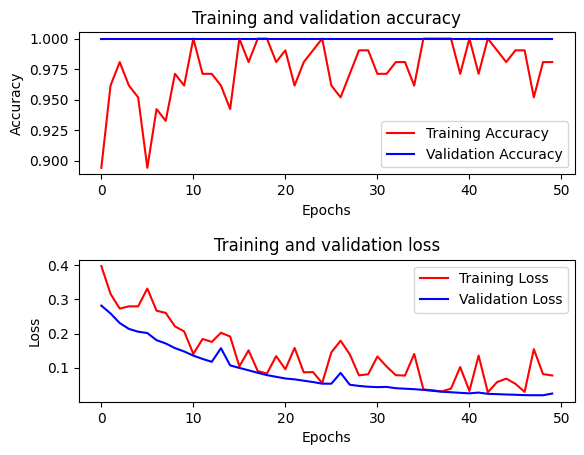

In [31]:
plot_history(history4)

In [33]:
# Evalaute the performance of the model on the test dataset

test_loss, test_acc, test_f1 = model4.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest F1 score:', test_f1)

28/28 - 41s - loss: 0.1839 - accuracy: 0.9643 - f1_score: 0.9095 - 41s/epoch - 1s/step

Test accuracy: 0.9642857313156128

Test F1 score: 0.9095237851142883


In [34]:
# Save the model weights, history and everything esle

import pickle

#Save the model

model4.save('/content/drive/My Drive/CNN_LSTM_model.keras')

#Save the history object

with open('history4.pkl', 'wb') as file:
    pickle.dump(history4.history, file)


In [ ]:
from keras.models import load_model
import pickle

#Load the model

custom_objects={'f1_score': f1_score}
model4 = load_model('/content/drive/My Drive/CNN_LSTM_model.keras', custom_objects=custom_objects)


# Load the history object
with open('history4.pkl', 'rb') as file:
    history4 = pickle.load(file)